# MLP 3 - FashionMNIST

In [1]:
import numpy as np
import cupy as cp
import pathlib
import pickle
import csv
import sys

In [2]:
sys.path.append(str(pathlib.Path('../../').resolve()))

In [3]:
from lib.experiments import train_test_experiment, build_MLP, build_augmentation_pipeline
from lib.utils.enums import NonLinearity, Initialization, Dataset, OptimizerName
from lib.utils.data import load_integer_dataset

## Experiments config

In [5]:
num_fc_layers = 4
num_fc_hidden = [1024, 1024, 1024]

In [6]:
dataset_config = dict(
    dataset=Dataset.FASHION_MNIST.name,
    subsample_ratio=1.0,
    ohe_values=(0, 32),
    data_augmentation=True,
    normalize=True,
)

In [7]:
network_config = dict(
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    dropout_rate=0.0,
    seed=42,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    bias=False,
    debug=False,
)

In [8]:
training_config = dict(
    batch_size=64,
    num_epochs=150,
    lr_inv=512,
    lr_amp_factor=640,
    fwd_decay_inv=29_000,
    subnet_decay_inv=6000,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [9]:
config = dataset_config | network_config | training_config

## Run the configuration

Training on 60000 samples


Data normalized. New statistics:
-  Min: -45
-  Max: 114
- Mean: 0
-  Std: 56

Moved data to device: <CUDA Device 1>
Train set:  (60000, 1, 28, 28), (60000, 10)
Test set:   (10000, 1, 28, 28), (10000, 10)
Data types: (int8, int8)


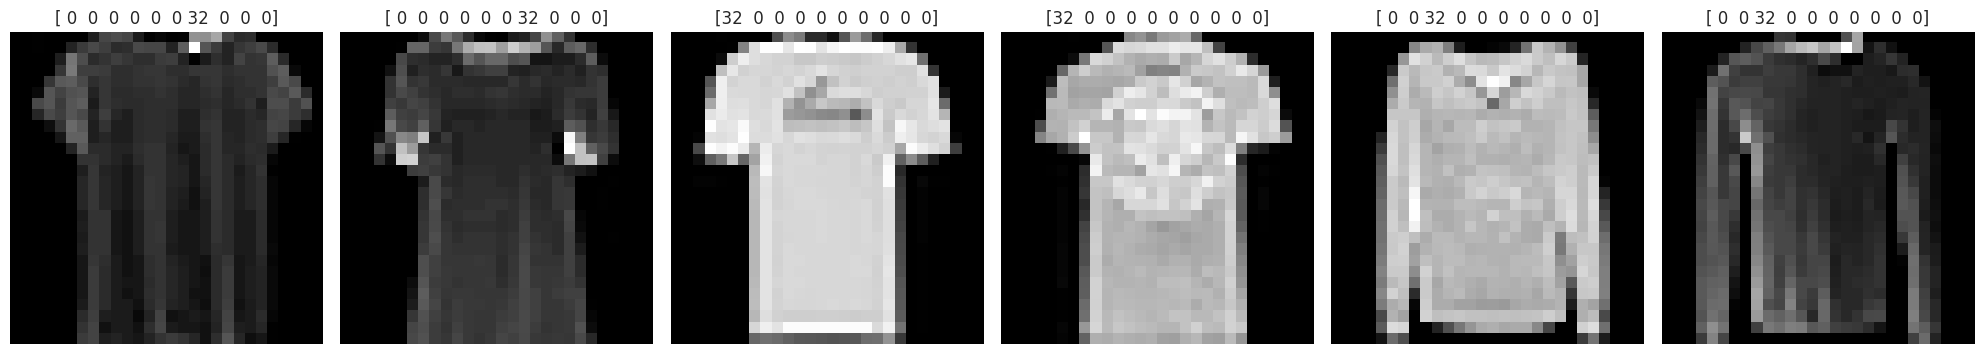

In [10]:
# Show the data and the model
dataset = load_integer_dataset(config, ohe_values=config["ohe_values"], val_dim=0, show_images=True, data_path='../.data')
X_train, _, _, y_train, _, _ = dataset

In [11]:
model = build_MLP(config, X_tr=X_train, y_tr=y_train)
print(model.extra_repr(1))

IntegerLocalLossMLP(
	(0): Sequential(
			(0): Flatten()
			(1): LocalLinearBlock(
			(0): IntegerLinear(in_features=784, out_features=1024, bias=False, decay_rate_inv=29000)
			(1): ConstantScaling(fwd_factor=200704, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=1024, out_features=10, bias=False, decay_rate_inv=6000)
			(1): ConstantScaling(fwd_factor=262144, bwd_factor=1)
		)
	)
			(2): LocalLinearBlock(
			(0): IntegerLinear(in_features=1024, out_features=1024, bias=False, decay_rate_inv=29000)
			(1): ConstantScaling(fwd_factor=262144, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=1024, out_features=10, bias=False, decay_rate_inv=6000)
			(1): ConstantScaling(fwd_factor=262144, bwd_factor=1)
		)
	)
			(3): LocalLinearBlock(
			(0): IntegerLinear(in_features=1024, out_features=1024, bias=False, decay_rate_inv=29000)
			(1):

In [12]:
def run_experiment(exp_config):
    # Setup reproducibility
    print(f"{'-' * 64}")
    print(f"Running experiment with seed {exp_config['seed']}...")
    np.random.seed(exp_config["seed"])
    cp.random.seed(exp_config["seed"])
    
    # Load the dataset
    data = load_integer_dataset(exp_config, ohe_values=exp_config["ohe_values"], val_dim=0, show_images=False, show_log=False, data_path='../.data')
    X_tr, _, X_test, y_tr, _, y_test = data

    # Setup data augmentation
    augmentation_pipeline = build_augmentation_pipeline(exp_config)
    
    # Build and train the model
    m = build_MLP(exp_config, X_tr=X_tr, y_tr=y_tr)    
    best_train_acc, best_test_acc = train_test_experiment(
        m, exp_config, X_tr=X_tr, X_te=X_test, y_tr=y_tr, y_te=y_test,
        augmentation_pipeline=augmentation_pipeline,
        show_local_accuracies=False, show_progress_bar=False
    )

    # Append the results to a CSV file
    with open('./results.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([exp_config["seed"], best_train_acc, best_test_acc])
        
    # Save the first model
    if not pathlib.Path('model.pkl').exists():
        with open('model.pkl', 'wb') as f:
            pickle.dump(m, f)

In [13]:
N_EXPERIMENTS = 10
for i in range(N_EXPERIMENTS):
    run_experiment(config)
    config["seed"] += 1

----------------------------------------------------------------
Running experiment with seed 42...


Epoch   1/150 - Train accuracy: 14.915% - Test accuracy: 37.790%


Epoch   2/150 - Train accuracy: 61.726% - Test accuracy: 74.990%


Epoch   3/150 - Train accuracy: 73.639% - Test accuracy: 77.063%


Epoch   4/150 - Train accuracy: 76.292% - Test accuracy: 79.637%


Epoch   5/150 - Train accuracy: 78.177% - Test accuracy: 81.721%


Epoch   6/150 - Train accuracy: 79.607% - Test accuracy: 82.121%


Epoch   7/150 - Train accuracy: 80.294% - Test accuracy: 83.173%


Epoch   8/150 - Train accuracy: 81.490% - Test accuracy: 83.924%


Epoch   9/150 - Train accuracy: 81.929% - Test accuracy: 84.605%


Epoch  10/150 - Train accuracy: 82.246% - Test accuracy: 85.046%


Epoch  11/150 - Train accuracy: 83.073% - Test accuracy: 85.016%


Epoch  12/150 - Train accuracy: 83.401% - Test accuracy: 84.996%


Epoch  13/150 - Train accuracy: 83.703% - Test accuracy: 85.186%


Epoch  14/150 - Train accuracy: 83.771% - Test accuracy: 85.787%


Epoch  15/150 - Train accuracy: 84.220% - Test accuracy: 85.988%


Epoch  16/150 - Train accuracy: 84.588% - Test accuracy: 85.978%


Epoch  17/150 - Train accuracy: 84.670% - Test accuracy: 86.138%


Epoch  18/150 - Train accuracy: 84.922% - Test accuracy: 86.268%


Epoch  19/150 - Train accuracy: 85.259% - Test accuracy: 86.759%


Epoch  20/150 - Train accuracy: 85.376% - Test accuracy: 86.288%


Epoch  21/150 - Train accuracy: 85.612% - Test accuracy: 86.969%


Epoch  22/150 - Train accuracy: 85.847% - Test accuracy: 86.829%


Epoch  23/150 - Train accuracy: 85.826% - Test accuracy: 87.220%


Epoch  24/150 - Train accuracy: 86.176% - Test accuracy: 86.709%


Epoch  25/150 - Train accuracy: 86.328% - Test accuracy: 86.248%


Epoch  26/150 - Train accuracy: 86.323% - Test accuracy: 87.240%


Epoch  27/150 - Train accuracy: 86.563% - Test accuracy: 87.590%


Epoch  28/150 - Train accuracy: 86.429% - Test accuracy: 87.450%


Epoch  29/150 - Train accuracy: 86.448% - Test accuracy: 87.550%


Epoch  30/150 - Train accuracy: 86.895% - Test accuracy: 87.740%


Epoch  31/150 - Train accuracy: 86.790% - Test accuracy: 87.580%


Epoch  32/150 - Train accuracy: 86.991% - Test accuracy: 87.520%


Epoch  33/150 - Train accuracy: 87.040% - Test accuracy: 88.141%


Epoch  34/150 - Train accuracy: 87.095% - Test accuracy: 87.660%


Epoch  35/150 - Train accuracy: 87.086% - Test accuracy: 87.831%


Epoch  36/150 - Train accuracy: 87.218% - Test accuracy: 87.500%


Epoch  37/150 - Train accuracy: 87.230% - Test accuracy: 87.470%


Epoch  38/150 - Train accuracy: 87.342% - Test accuracy: 88.121%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 38
----------------------------------------------------------------


Epoch  39/150 - Train accuracy: 87.957% - Test accuracy: 88.411%


Epoch  40/150 - Train accuracy: 88.150% - Test accuracy: 88.522%


Epoch  41/150 - Train accuracy: 88.157% - Test accuracy: 88.542%


Epoch  42/150 - Train accuracy: 87.995% - Test accuracy: 88.602%


Epoch  43/150 - Train accuracy: 88.017% - Test accuracy: 88.512%


Epoch  44/150 - Train accuracy: 88.247% - Test accuracy: 88.211%


Epoch  45/150 - Train accuracy: 88.319% - Test accuracy: 88.401%


Epoch  46/150 - Train accuracy: 88.389% - Test accuracy: 88.552%


Epoch  47/150 - Train accuracy: 88.340% - Test accuracy: 88.552%


Epoch  48/150 - Train accuracy: 88.442% - Test accuracy: 88.522%


Epoch  49/150 - Train accuracy: 88.330% - Test accuracy: 88.642%


Epoch  50/150 - Train accuracy: 88.294% - Test accuracy: 88.452%


Epoch  51/150 - Train accuracy: 88.324% - Test accuracy: 88.712%


Epoch  52/150 - Train accuracy: 88.325% - Test accuracy: 88.612%


Epoch  53/150 - Train accuracy: 88.434% - Test accuracy: 88.782%


Epoch  54/150 - Train accuracy: 88.430% - Test accuracy: 88.592%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 54
----------------------------------------------------------------


Epoch  55/150 - Train accuracy: 88.777% - Test accuracy: 88.812%


Epoch  56/150 - Train accuracy: 88.566% - Test accuracy: 88.922%


Epoch  57/150 - Train accuracy: 88.769% - Test accuracy: 88.912%


Epoch  58/150 - Train accuracy: 88.567% - Test accuracy: 89.022%


Epoch  59/150 - Train accuracy: 88.772% - Test accuracy: 88.902%


Epoch  60/150 - Train accuracy: 88.526% - Test accuracy: 88.862%


Epoch  61/150 - Train accuracy: 88.474% - Test accuracy: 88.922%


Epoch  62/150 - Train accuracy: 88.592% - Test accuracy: 88.862%


Epoch  63/150 - Train accuracy: 88.592% - Test accuracy: 89.012%


Epoch  64/150 - Train accuracy: 88.777% - Test accuracy: 88.842%


Epoch  65/150 - Train accuracy: 88.624% - Test accuracy: 88.772%


Epoch  66/150 - Train accuracy: 88.644% - Test accuracy: 88.992%


Epoch  67/150 - Train accuracy: 88.557% - Test accuracy: 89.032%


Epoch  68/150 - Train accuracy: 88.777% - Test accuracy: 88.952%


Epoch  69/150 - Train accuracy: 88.841% - Test accuracy: 89.012%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 69
----------------------------------------------------------------


Epoch  70/150 - Train accuracy: 88.872% - Test accuracy: 88.842%


Epoch  71/150 - Train accuracy: 88.759% - Test accuracy: 89.022%


Epoch  72/150 - Train accuracy: 88.859% - Test accuracy: 88.922%


Epoch  73/150 - Train accuracy: 88.717% - Test accuracy: 88.962%


Epoch  74/150 - Train accuracy: 88.804% - Test accuracy: 88.962%


Epoch  75/150 - Train accuracy: 88.817% - Test accuracy: 89.073%


Epoch  76/150 - Train accuracy: 88.997% - Test accuracy: 88.942%


Epoch  77/150 - Train accuracy: 88.897% - Test accuracy: 89.113%


Epoch  78/150 - Train accuracy: 88.854% - Test accuracy: 89.073%


Epoch  79/150 - Train accuracy: 88.846% - Test accuracy: 89.113%


Epoch  80/150 - Train accuracy: 88.976% - Test accuracy: 89.133%


Epoch  81/150 - Train accuracy: 88.912% - Test accuracy: 89.002%


Epoch  82/150 - Train accuracy: 88.751% - Test accuracy: 89.093%


Epoch  83/150 - Train accuracy: 88.766% - Test accuracy: 88.982%


Epoch  84/150 - Train accuracy: 88.801% - Test accuracy: 88.982%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 84
----------------------------------------------------------------


Epoch  85/150 - Train accuracy: 88.892% - Test accuracy: 88.982%


Epoch  86/150 - Train accuracy: 88.949% - Test accuracy: 88.982%


Epoch  87/150 - Train accuracy: 88.719% - Test accuracy: 89.022%


Epoch  88/150 - Train accuracy: 88.759% - Test accuracy: 89.032%
----------------------------------------------------------------
Early stopping at epoch 88
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 43...


Epoch   1/150 - Train accuracy: 15.383% - Test accuracy: 46.705%


Epoch   2/150 - Train accuracy: 62.210% - Test accuracy: 74.930%


Epoch   3/150 - Train accuracy: 73.438% - Test accuracy: 76.923%


Epoch   4/150 - Train accuracy: 76.012% - Test accuracy: 80.519%


Epoch   5/150 - Train accuracy: 78.288% - Test accuracy: 80.529%


Epoch   6/150 - Train accuracy: 79.264% - Test accuracy: 82.903%


Epoch   7/150 - Train accuracy: 80.338% - Test accuracy: 83.303%


Epoch   8/150 - Train accuracy: 81.112% - Test accuracy: 83.474%


Epoch   9/150 - Train accuracy: 81.832% - Test accuracy: 84.185%


Epoch  10/150 - Train accuracy: 82.216% - Test accuracy: 83.534%


Epoch  11/150 - Train accuracy: 82.986% - Test accuracy: 84.836%


Epoch  12/150 - Train accuracy: 83.281% - Test accuracy: 85.256%


Epoch  13/150 - Train accuracy: 83.595% - Test accuracy: 85.517%


Epoch  14/150 - Train accuracy: 83.870% - Test accuracy: 85.807%


Epoch  15/150 - Train accuracy: 84.233% - Test accuracy: 85.627%


Epoch  16/150 - Train accuracy: 84.433% - Test accuracy: 86.128%


Epoch  17/150 - Train accuracy: 84.677% - Test accuracy: 86.378%


Epoch  18/150 - Train accuracy: 84.867% - Test accuracy: 86.609%


Epoch  19/150 - Train accuracy: 85.200% - Test accuracy: 86.318%


Epoch  20/150 - Train accuracy: 85.479% - Test accuracy: 86.849%


Epoch  21/150 - Train accuracy: 85.494% - Test accuracy: 85.597%


Epoch  22/150 - Train accuracy: 85.492% - Test accuracy: 86.979%


Epoch  23/150 - Train accuracy: 85.881% - Test accuracy: 86.869%


Epoch  24/150 - Train accuracy: 85.939% - Test accuracy: 86.358%


Epoch  25/150 - Train accuracy: 86.146% - Test accuracy: 87.139%


Epoch  26/150 - Train accuracy: 86.004% - Test accuracy: 87.310%


Epoch  27/150 - Train accuracy: 86.323% - Test accuracy: 87.560%


Epoch  28/150 - Train accuracy: 86.431% - Test accuracy: 87.260%


Epoch  29/150 - Train accuracy: 86.553% - Test accuracy: 87.179%


Epoch  30/150 - Train accuracy: 86.710% - Test accuracy: 87.480%


Epoch  31/150 - Train accuracy: 86.463% - Test accuracy: 87.620%


Epoch  32/150 - Train accuracy: 86.806% - Test accuracy: 87.590%


Epoch  33/150 - Train accuracy: 86.993% - Test accuracy: 87.450%


Epoch  34/150 - Train accuracy: 87.178% - Test accuracy: 87.640%


Epoch  35/150 - Train accuracy: 86.803% - Test accuracy: 88.051%


Epoch  36/150 - Train accuracy: 87.133% - Test accuracy: 87.861%


Epoch  37/150 - Train accuracy: 87.568% - Test accuracy: 87.690%


Epoch  38/150 - Train accuracy: 87.483% - Test accuracy: 87.951%


Epoch  39/150 - Train accuracy: 87.310% - Test accuracy: 87.740%


Epoch  40/150 - Train accuracy: 87.335% - Test accuracy: 88.091%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 40
----------------------------------------------------------------


Epoch  41/150 - Train accuracy: 87.920% - Test accuracy: 88.492%


Epoch  42/150 - Train accuracy: 88.185% - Test accuracy: 88.331%


Epoch  43/150 - Train accuracy: 88.209% - Test accuracy: 88.251%


Epoch  44/150 - Train accuracy: 88.047% - Test accuracy: 88.371%


Epoch  45/150 - Train accuracy: 88.212% - Test accuracy: 88.502%


Epoch  46/150 - Train accuracy: 88.277% - Test accuracy: 88.482%


Epoch  47/150 - Train accuracy: 88.072% - Test accuracy: 88.411%


Epoch  48/150 - Train accuracy: 88.219% - Test accuracy: 88.361%


Epoch  49/150 - Train accuracy: 88.501% - Test accuracy: 88.301%


Epoch  50/150 - Train accuracy: 88.145% - Test accuracy: 88.622%


Epoch  51/150 - Train accuracy: 88.370% - Test accuracy: 88.111%


Epoch  52/150 - Train accuracy: 88.072% - Test accuracy: 88.632%


Epoch  53/150 - Train accuracy: 88.380% - Test accuracy: 88.411%


Epoch  54/150 - Train accuracy: 88.344% - Test accuracy: 88.652%


Epoch  55/150 - Train accuracy: 88.542% - Test accuracy: 88.431%


Epoch  56/150 - Train accuracy: 88.459% - Test accuracy: 88.582%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 56
----------------------------------------------------------------


Epoch  57/150 - Train accuracy: 88.577% - Test accuracy: 88.762%


Epoch  58/150 - Train accuracy: 88.799% - Test accuracy: 88.572%


Epoch  59/150 - Train accuracy: 88.661% - Test accuracy: 88.692%


Epoch  60/150 - Train accuracy: 88.767% - Test accuracy: 88.682%


Epoch  61/150 - Train accuracy: 88.762% - Test accuracy: 88.782%


Epoch  62/150 - Train accuracy: 88.984% - Test accuracy: 88.792%


Epoch  63/150 - Train accuracy: 88.632% - Test accuracy: 88.852%


Epoch  64/150 - Train accuracy: 88.816% - Test accuracy: 88.652%


Epoch  65/150 - Train accuracy: 88.539% - Test accuracy: 88.782%


Epoch  66/150 - Train accuracy: 88.736% - Test accuracy: 88.862%


Epoch  67/150 - Train accuracy: 88.851% - Test accuracy: 88.782%


Epoch  68/150 - Train accuracy: 88.887% - Test accuracy: 88.762%


Epoch  69/150 - Train accuracy: 88.654% - Test accuracy: 88.832%


Epoch  70/150 - Train accuracy: 88.477% - Test accuracy: 88.842%


Epoch  71/150 - Train accuracy: 88.639% - Test accuracy: 88.892%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 71
----------------------------------------------------------------


Epoch  72/150 - Train accuracy: 88.804% - Test accuracy: 88.822%


Epoch  73/150 - Train accuracy: 88.826% - Test accuracy: 88.902%


Epoch  74/150 - Train accuracy: 88.714% - Test accuracy: 88.882%


Epoch  75/150 - Train accuracy: 88.894% - Test accuracy: 88.822%


Epoch  76/150 - Train accuracy: 89.032% - Test accuracy: 88.842%
----------------------------------------------------------------
Early stopping at epoch 76
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 44...


Epoch   1/150 - Train accuracy: 15.717% - Test accuracy: 43.099%


Epoch   2/150 - Train accuracy: 62.385% - Test accuracy: 74.549%


Epoch   3/150 - Train accuracy: 73.432% - Test accuracy: 76.753%


Epoch   4/150 - Train accuracy: 76.019% - Test accuracy: 79.758%


Epoch   5/150 - Train accuracy: 78.455% - Test accuracy: 81.490%


Epoch   6/150 - Train accuracy: 79.569% - Test accuracy: 82.202%


Epoch   7/150 - Train accuracy: 80.116% - Test accuracy: 82.823%


Epoch   8/150 - Train accuracy: 81.218% - Test accuracy: 84.125%


Epoch   9/150 - Train accuracy: 81.772% - Test accuracy: 84.145%


Epoch  10/150 - Train accuracy: 82.079% - Test accuracy: 84.665%


Epoch  11/150 - Train accuracy: 82.677% - Test accuracy: 85.056%


Epoch  12/150 - Train accuracy: 83.226% - Test accuracy: 85.276%


Epoch  13/150 - Train accuracy: 83.663% - Test accuracy: 85.016%


Epoch  14/150 - Train accuracy: 84.020% - Test accuracy: 85.607%


Epoch  15/150 - Train accuracy: 84.333% - Test accuracy: 85.847%


Epoch  16/150 - Train accuracy: 84.348% - Test accuracy: 85.797%


Epoch  17/150 - Train accuracy: 84.750% - Test accuracy: 86.569%


Epoch  18/150 - Train accuracy: 84.814% - Test accuracy: 86.228%


Epoch  19/150 - Train accuracy: 85.377% - Test accuracy: 86.769%


Epoch  20/150 - Train accuracy: 85.172% - Test accuracy: 85.998%


Epoch  21/150 - Train accuracy: 85.347% - Test accuracy: 86.699%


Epoch  22/150 - Train accuracy: 85.521% - Test accuracy: 87.099%


Epoch  23/150 - Train accuracy: 85.769% - Test accuracy: 86.028%


Epoch  24/150 - Train accuracy: 85.909% - Test accuracy: 87.149%


Epoch  25/150 - Train accuracy: 86.199% - Test accuracy: 87.149%


Epoch  26/150 - Train accuracy: 86.284% - Test accuracy: 87.290%


Epoch  27/150 - Train accuracy: 86.399% - Test accuracy: 87.200%


Epoch  28/150 - Train accuracy: 86.491% - Test accuracy: 87.210%


Epoch  29/150 - Train accuracy: 86.668% - Test accuracy: 86.869%


Epoch  30/150 - Train accuracy: 86.856% - Test accuracy: 87.410%


Epoch  31/150 - Train accuracy: 86.728% - Test accuracy: 87.810%


Epoch  32/150 - Train accuracy: 87.051% - Test accuracy: 87.580%


Epoch  33/150 - Train accuracy: 87.010% - Test accuracy: 88.051%


Epoch  34/150 - Train accuracy: 87.000% - Test accuracy: 87.560%


Epoch  35/150 - Train accuracy: 87.061% - Test accuracy: 87.720%


Epoch  36/150 - Train accuracy: 87.146% - Test accuracy: 87.961%


Epoch  37/150 - Train accuracy: 87.118% - Test accuracy: 87.961%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 37
----------------------------------------------------------------


Epoch  38/150 - Train accuracy: 87.964% - Test accuracy: 88.351%


Epoch  39/150 - Train accuracy: 88.007% - Test accuracy: 88.271%


Epoch  40/150 - Train accuracy: 88.015% - Test accuracy: 88.051%


Epoch  41/150 - Train accuracy: 88.154% - Test accuracy: 88.301%


Epoch  42/150 - Train accuracy: 88.107% - Test accuracy: 88.311%


Epoch  43/150 - Train accuracy: 88.180% - Test accuracy: 88.552%


Epoch  44/150 - Train accuracy: 88.180% - Test accuracy: 88.492%


Epoch  45/150 - Train accuracy: 88.215% - Test accuracy: 88.381%


Epoch  46/150 - Train accuracy: 88.419% - Test accuracy: 88.371%


Epoch  47/150 - Train accuracy: 88.302% - Test accuracy: 88.792%


Epoch  48/150 - Train accuracy: 88.447% - Test accuracy: 88.802%


Epoch  49/150 - Train accuracy: 88.164% - Test accuracy: 88.442%


Epoch  50/150 - Train accuracy: 88.330% - Test accuracy: 88.702%


Epoch  51/150 - Train accuracy: 88.137% - Test accuracy: 88.421%


Epoch  52/150 - Train accuracy: 88.297% - Test accuracy: 88.131%


Epoch  53/150 - Train accuracy: 88.290% - Test accuracy: 88.712%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 53
----------------------------------------------------------------


Epoch  54/150 - Train accuracy: 88.772% - Test accuracy: 88.982%


Epoch  55/150 - Train accuracy: 88.639% - Test accuracy: 88.472%


Epoch  56/150 - Train accuracy: 88.627% - Test accuracy: 88.992%


Epoch  57/150 - Train accuracy: 88.549% - Test accuracy: 88.882%


Epoch  58/150 - Train accuracy: 88.662% - Test accuracy: 88.822%


Epoch  59/150 - Train accuracy: 88.494% - Test accuracy: 89.022%


Epoch  60/150 - Train accuracy: 88.794% - Test accuracy: 88.672%


Epoch  61/150 - Train accuracy: 88.651% - Test accuracy: 88.762%


Epoch  62/150 - Train accuracy: 88.651% - Test accuracy: 88.742%


Epoch  63/150 - Train accuracy: 88.814% - Test accuracy: 88.912%


Epoch  64/150 - Train accuracy: 88.899% - Test accuracy: 89.083%


Epoch  65/150 - Train accuracy: 88.767% - Test accuracy: 88.842%


Epoch  66/150 - Train accuracy: 88.617% - Test accuracy: 88.872%


Epoch  67/150 - Train accuracy: 88.691% - Test accuracy: 88.942%


Epoch  68/150 - Train accuracy: 88.721% - Test accuracy: 88.972%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 68
----------------------------------------------------------------


Epoch  69/150 - Train accuracy: 89.004% - Test accuracy: 88.812%


Epoch  70/150 - Train accuracy: 88.567% - Test accuracy: 88.972%


Epoch  71/150 - Train accuracy: 88.649% - Test accuracy: 88.922%


Epoch  72/150 - Train accuracy: 88.811% - Test accuracy: 88.972%


Epoch  73/150 - Train accuracy: 88.631% - Test accuracy: 88.992%


Epoch  74/150 - Train accuracy: 88.699% - Test accuracy: 89.052%


Epoch  75/150 - Train accuracy: 88.591% - Test accuracy: 89.062%


Epoch  76/150 - Train accuracy: 88.816% - Test accuracy: 88.982%


Epoch  77/150 - Train accuracy: 88.559% - Test accuracy: 88.952%


Epoch  78/150 - Train accuracy: 88.672% - Test accuracy: 88.942%
----------------------------------------------------------------
Early stopping at epoch 78
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 45...


Epoch   1/150 - Train accuracy: 14.609% - Test accuracy: 41.026%


Epoch   2/150 - Train accuracy: 61.193% - Test accuracy: 75.230%


Epoch   3/150 - Train accuracy: 73.624% - Test accuracy: 77.023%


Epoch   4/150 - Train accuracy: 76.142% - Test accuracy: 80.569%


Epoch   5/150 - Train accuracy: 78.102% - Test accuracy: 81.380%


Epoch   6/150 - Train accuracy: 79.534% - Test accuracy: 82.843%


Epoch   7/150 - Train accuracy: 80.488% - Test accuracy: 83.053%


Epoch   8/150 - Train accuracy: 81.372% - Test accuracy: 83.624%


Epoch   9/150 - Train accuracy: 82.169% - Test accuracy: 84.375%


Epoch  10/150 - Train accuracy: 82.412% - Test accuracy: 84.896%


Epoch  11/150 - Train accuracy: 82.976% - Test accuracy: 84.886%


Epoch  12/150 - Train accuracy: 83.476% - Test accuracy: 85.387%


Epoch  13/150 - Train accuracy: 83.441% - Test accuracy: 85.547%


Epoch  14/150 - Train accuracy: 83.791% - Test accuracy: 85.958%


Epoch  15/150 - Train accuracy: 84.542% - Test accuracy: 85.927%


Epoch  16/150 - Train accuracy: 84.475% - Test accuracy: 85.827%


Epoch  17/150 - Train accuracy: 84.694% - Test accuracy: 86.208%


Epoch  18/150 - Train accuracy: 85.082% - Test accuracy: 86.558%


Epoch  19/150 - Train accuracy: 85.299% - Test accuracy: 86.538%


Epoch  20/150 - Train accuracy: 85.312% - Test accuracy: 85.847%


Epoch  21/150 - Train accuracy: 85.592% - Test accuracy: 86.789%


Epoch  22/150 - Train accuracy: 85.506% - Test accuracy: 87.179%


Epoch  23/150 - Train accuracy: 85.856% - Test accuracy: 87.059%


Epoch  24/150 - Train accuracy: 85.912% - Test accuracy: 86.959%


Epoch  25/150 - Train accuracy: 86.106% - Test accuracy: 86.679%


Epoch  26/150 - Train accuracy: 86.298% - Test accuracy: 87.240%


Epoch  27/150 - Train accuracy: 86.333% - Test accuracy: 87.159%


Epoch  28/150 - Train accuracy: 86.289% - Test accuracy: 87.009%


Epoch  29/150 - Train accuracy: 86.473% - Test accuracy: 87.260%


Epoch  30/150 - Train accuracy: 86.691% - Test accuracy: 87.911%


Epoch  31/150 - Train accuracy: 86.810% - Test accuracy: 87.760%


Epoch  32/150 - Train accuracy: 87.033% - Test accuracy: 87.760%


Epoch  33/150 - Train accuracy: 86.921% - Test accuracy: 87.330%


Epoch  34/150 - Train accuracy: 87.091% - Test accuracy: 87.901%


Epoch  35/150 - Train accuracy: 86.955% - Test accuracy: 88.031%


Epoch  36/150 - Train accuracy: 87.011% - Test accuracy: 87.800%


Epoch  37/150 - Train accuracy: 87.338% - Test accuracy: 88.151%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 37
----------------------------------------------------------------


Epoch  38/150 - Train accuracy: 87.880% - Test accuracy: 88.111%


Epoch  39/150 - Train accuracy: 88.089% - Test accuracy: 88.472%


Epoch  40/150 - Train accuracy: 88.010% - Test accuracy: 88.512%


Epoch  41/150 - Train accuracy: 88.012% - Test accuracy: 88.361%


Epoch  42/150 - Train accuracy: 87.927% - Test accuracy: 88.552%


Epoch  43/150 - Train accuracy: 88.055% - Test accuracy: 88.061%


Epoch  44/150 - Train accuracy: 88.412% - Test accuracy: 88.351%


Epoch  45/150 - Train accuracy: 87.997% - Test accuracy: 88.241%


Epoch  46/150 - Train accuracy: 87.935% - Test accuracy: 88.462%


Epoch  47/150 - Train accuracy: 88.174% - Test accuracy: 88.452%


Epoch  48/150 - Train accuracy: 88.159% - Test accuracy: 88.391%


Epoch  49/150 - Train accuracy: 88.185% - Test accuracy: 88.512%


Epoch  50/150 - Train accuracy: 88.232% - Test accuracy: 88.552%


Epoch  51/150 - Train accuracy: 88.345% - Test accuracy: 88.672%


Epoch  52/150 - Train accuracy: 88.174% - Test accuracy: 88.622%


Epoch  53/150 - Train accuracy: 88.310% - Test accuracy: 88.532%


Epoch  54/150 - Train accuracy: 88.224% - Test accuracy: 88.411%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 54
----------------------------------------------------------------


Epoch  55/150 - Train accuracy: 88.417% - Test accuracy: 88.572%


Epoch  56/150 - Train accuracy: 88.674% - Test accuracy: 88.682%


Epoch  57/150 - Train accuracy: 88.504% - Test accuracy: 88.652%


Epoch  58/150 - Train accuracy: 88.434% - Test accuracy: 88.592%


Epoch  59/150 - Train accuracy: 88.312% - Test accuracy: 88.632%


Epoch  60/150 - Train accuracy: 88.596% - Test accuracy: 88.752%


Epoch  61/150 - Train accuracy: 88.577% - Test accuracy: 88.712%


Epoch  62/150 - Train accuracy: 88.479% - Test accuracy: 88.702%


Epoch  63/150 - Train accuracy: 88.524% - Test accuracy: 88.802%


Epoch  64/150 - Train accuracy: 88.492% - Test accuracy: 88.822%


Epoch  65/150 - Train accuracy: 88.627% - Test accuracy: 88.692%
----------------------------------------------------------------
Early stopping at epoch 65
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 46...


Epoch   1/150 - Train accuracy: 15.913% - Test accuracy: 43.730%


Epoch   2/150 - Train accuracy: 61.986% - Test accuracy: 75.611%


Epoch   3/150 - Train accuracy: 73.571% - Test accuracy: 76.863%


Epoch   4/150 - Train accuracy: 75.869% - Test accuracy: 80.419%


Epoch   5/150 - Train accuracy: 78.353% - Test accuracy: 81.721%


Epoch   6/150 - Train accuracy: 79.759% - Test accuracy: 82.712%


Epoch   7/150 - Train accuracy: 80.463% - Test accuracy: 83.173%


Epoch   8/150 - Train accuracy: 81.480% - Test accuracy: 84.075%


Epoch   9/150 - Train accuracy: 82.125% - Test accuracy: 83.584%


Epoch  10/150 - Train accuracy: 82.669% - Test accuracy: 84.876%


Epoch  11/150 - Train accuracy: 82.976% - Test accuracy: 84.385%


Epoch  12/150 - Train accuracy: 83.451% - Test accuracy: 85.497%


Epoch  13/150 - Train accuracy: 83.680% - Test accuracy: 85.377%


Epoch  14/150 - Train accuracy: 84.082% - Test accuracy: 85.557%


Epoch  15/150 - Train accuracy: 84.115% - Test accuracy: 85.827%


Epoch  16/150 - Train accuracy: 84.542% - Test accuracy: 85.998%


Epoch  17/150 - Train accuracy: 84.777% - Test accuracy: 86.088%


Epoch  18/150 - Train accuracy: 84.889% - Test accuracy: 86.158%


Epoch  19/150 - Train accuracy: 85.087% - Test accuracy: 86.719%


Epoch  20/150 - Train accuracy: 85.707% - Test accuracy: 86.378%


Epoch  21/150 - Train accuracy: 85.724% - Test accuracy: 86.659%


Epoch  22/150 - Train accuracy: 85.659% - Test accuracy: 86.889%


Epoch  23/150 - Train accuracy: 85.844% - Test accuracy: 87.179%


Epoch  24/150 - Train accuracy: 86.134% - Test accuracy: 87.220%


Epoch  25/150 - Train accuracy: 86.264% - Test accuracy: 87.129%


Epoch  26/150 - Train accuracy: 86.279% - Test accuracy: 87.470%


Epoch  27/150 - Train accuracy: 86.426% - Test accuracy: 87.410%


Epoch  28/150 - Train accuracy: 86.645% - Test accuracy: 87.129%


Epoch  29/150 - Train accuracy: 86.678% - Test accuracy: 87.831%


Epoch  30/150 - Train accuracy: 86.740% - Test accuracy: 87.119%


Epoch  31/150 - Train accuracy: 86.985% - Test accuracy: 87.570%


Epoch  32/150 - Train accuracy: 86.830% - Test accuracy: 87.720%


Epoch  33/150 - Train accuracy: 87.263% - Test accuracy: 87.861%


Epoch  34/150 - Train accuracy: 87.302% - Test accuracy: 88.041%


Epoch  35/150 - Train accuracy: 87.487% - Test accuracy: 88.131%


Epoch  36/150 - Train accuracy: 87.153% - Test accuracy: 88.191%


Epoch  37/150 - Train accuracy: 87.275% - Test accuracy: 88.121%


Epoch  38/150 - Train accuracy: 87.367% - Test accuracy: 87.981%


Epoch  39/150 - Train accuracy: 87.453% - Test accuracy: 87.961%


Epoch  40/150 - Train accuracy: 87.557% - Test accuracy: 87.881%


Epoch  41/150 - Train accuracy: 87.652% - Test accuracy: 88.281%


Epoch  42/150 - Train accuracy: 87.954% - Test accuracy: 88.552%


Epoch  43/150 - Train accuracy: 87.713% - Test accuracy: 88.381%


Epoch  44/150 - Train accuracy: 87.892% - Test accuracy: 88.131%


Epoch  45/150 - Train accuracy: 88.117% - Test accuracy: 87.931%


Epoch  46/150 - Train accuracy: 87.860% - Test accuracy: 88.281%


Epoch  47/150 - Train accuracy: 88.030% - Test accuracy: 87.921%


Epoch  48/150 - Train accuracy: 88.022% - Test accuracy: 88.361%


Epoch  49/150 - Train accuracy: 88.102% - Test accuracy: 88.542%


Epoch  50/150 - Train accuracy: 88.120% - Test accuracy: 88.552%


Epoch  51/150 - Train accuracy: 88.441% - Test accuracy: 88.822%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 51
----------------------------------------------------------------


Epoch  52/150 - Train accuracy: 88.729% - Test accuracy: 89.002%


Epoch  53/150 - Train accuracy: 88.709% - Test accuracy: 88.992%


Epoch  54/150 - Train accuracy: 88.754% - Test accuracy: 89.173%


Epoch  55/150 - Train accuracy: 88.849% - Test accuracy: 89.073%


Epoch  56/150 - Train accuracy: 88.821% - Test accuracy: 89.083%


Epoch  57/150 - Train accuracy: 88.951% - Test accuracy: 89.093%


Epoch  58/150 - Train accuracy: 88.954% - Test accuracy: 89.213%


Epoch  59/150 - Train accuracy: 89.109% - Test accuracy: 89.163%


Epoch  60/150 - Train accuracy: 88.869% - Test accuracy: 89.223%


Epoch  61/150 - Train accuracy: 88.974% - Test accuracy: 89.173%


Epoch  62/150 - Train accuracy: 89.176% - Test accuracy: 89.052%


Epoch  63/150 - Train accuracy: 89.089% - Test accuracy: 89.263%


Epoch  64/150 - Train accuracy: 89.056% - Test accuracy: 89.093%


Epoch  65/150 - Train accuracy: 89.259% - Test accuracy: 89.143%


Epoch  66/150 - Train accuracy: 89.166% - Test accuracy: 89.203%


Epoch  67/150 - Train accuracy: 89.258% - Test accuracy: 89.293%


Epoch  68/150 - Train accuracy: 89.134% - Test accuracy: 89.062%


Epoch  69/150 - Train accuracy: 89.164% - Test accuracy: 89.042%


Epoch  70/150 - Train accuracy: 89.294% - Test accuracy: 89.283%


Epoch  71/150 - Train accuracy: 89.309% - Test accuracy: 89.333%


Epoch  72/150 - Train accuracy: 89.148% - Test accuracy: 89.393%


Epoch  73/150 - Train accuracy: 89.188% - Test accuracy: 89.042%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 73
----------------------------------------------------------------


Epoch  74/150 - Train accuracy: 89.488% - Test accuracy: 89.453%


Epoch  75/150 - Train accuracy: 89.456% - Test accuracy: 89.233%


Epoch  76/150 - Train accuracy: 89.489% - Test accuracy: 89.343%


Epoch  77/150 - Train accuracy: 89.544% - Test accuracy: 89.393%


Epoch  78/150 - Train accuracy: 89.334% - Test accuracy: 89.473%


Epoch  79/150 - Train accuracy: 89.508% - Test accuracy: 89.453%


Epoch  80/150 - Train accuracy: 89.523% - Test accuracy: 89.463%


Epoch  81/150 - Train accuracy: 89.354% - Test accuracy: 89.453%


Epoch  82/150 - Train accuracy: 89.353% - Test accuracy: 89.443%


Epoch  83/150 - Train accuracy: 89.476% - Test accuracy: 89.363%


Epoch  84/150 - Train accuracy: 89.349% - Test accuracy: 89.373%


Epoch  85/150 - Train accuracy: 89.406% - Test accuracy: 89.393%


Epoch  86/150 - Train accuracy: 89.528% - Test accuracy: 89.473%


Epoch  87/150 - Train accuracy: 89.509% - Test accuracy: 89.273%


Epoch  88/150 - Train accuracy: 89.451% - Test accuracy: 89.443%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 88
----------------------------------------------------------------


Epoch  89/150 - Train accuracy: 89.401% - Test accuracy: 89.463%
----------------------------------------------------------------
Early stopping at epoch 89
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 47...


Epoch   1/150 - Train accuracy: 15.367% - Test accuracy: 34.876%


Epoch   2/150 - Train accuracy: 61.473% - Test accuracy: 73.988%


Epoch   3/150 - Train accuracy: 73.441% - Test accuracy: 76.893%


Epoch   4/150 - Train accuracy: 76.087% - Test accuracy: 80.138%


Epoch   5/150 - Train accuracy: 78.350% - Test accuracy: 80.599%


Epoch   6/150 - Train accuracy: 79.706% - Test accuracy: 82.542%


Epoch   7/150 - Train accuracy: 80.668% - Test accuracy: 82.903%


Epoch   8/150 - Train accuracy: 81.220% - Test accuracy: 83.964%


Epoch   9/150 - Train accuracy: 82.196% - Test accuracy: 84.375%


Epoch  10/150 - Train accuracy: 82.409% - Test accuracy: 84.195%


Epoch  11/150 - Train accuracy: 82.779% - Test accuracy: 84.555%


Epoch  12/150 - Train accuracy: 83.376% - Test accuracy: 84.786%


Epoch  13/150 - Train accuracy: 83.616% - Test accuracy: 85.417%


Epoch  14/150 - Train accuracy: 84.030% - Test accuracy: 85.537%


Epoch  15/150 - Train accuracy: 84.385% - Test accuracy: 85.517%


Epoch  16/150 - Train accuracy: 84.632% - Test accuracy: 85.457%


Epoch  17/150 - Train accuracy: 84.822% - Test accuracy: 86.198%


Epoch  18/150 - Train accuracy: 84.979% - Test accuracy: 86.438%


Epoch  19/150 - Train accuracy: 85.349% - Test accuracy: 86.779%


Epoch  20/150 - Train accuracy: 85.399% - Test accuracy: 86.308%


Epoch  21/150 - Train accuracy: 85.587% - Test accuracy: 87.069%


Epoch  22/150 - Train accuracy: 85.871% - Test accuracy: 85.687%


Epoch  23/150 - Train accuracy: 85.521% - Test accuracy: 86.318%


Epoch  24/150 - Train accuracy: 85.963% - Test accuracy: 86.639%


Epoch  25/150 - Train accuracy: 86.303% - Test accuracy: 87.420%


Epoch  26/150 - Train accuracy: 86.536% - Test accuracy: 87.600%


Epoch  27/150 - Train accuracy: 86.434% - Test accuracy: 87.190%


Epoch  28/150 - Train accuracy: 86.321% - Test accuracy: 86.869%


Epoch  29/150 - Train accuracy: 86.523% - Test accuracy: 87.730%


Epoch  30/150 - Train accuracy: 86.655% - Test accuracy: 86.759%


Epoch  31/150 - Train accuracy: 86.850% - Test accuracy: 87.540%


Epoch  32/150 - Train accuracy: 86.908% - Test accuracy: 87.821%


Epoch  33/150 - Train accuracy: 86.945% - Test accuracy: 87.440%


Epoch  34/150 - Train accuracy: 86.988% - Test accuracy: 87.240%


Epoch  35/150 - Train accuracy: 87.116% - Test accuracy: 87.670%


Epoch  36/150 - Train accuracy: 87.323% - Test accuracy: 87.750%


Epoch  37/150 - Train accuracy: 87.106% - Test accuracy: 87.510%


Epoch  38/150 - Train accuracy: 87.220% - Test accuracy: 87.800%


Epoch  39/150 - Train accuracy: 87.412% - Test accuracy: 87.670%


Epoch  40/150 - Train accuracy: 87.373% - Test accuracy: 88.201%


Epoch  41/150 - Train accuracy: 87.522% - Test accuracy: 87.851%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 41
----------------------------------------------------------------


Epoch  42/150 - Train accuracy: 87.949% - Test accuracy: 88.221%


Epoch  43/150 - Train accuracy: 88.115% - Test accuracy: 88.351%


Epoch  44/150 - Train accuracy: 88.250% - Test accuracy: 88.341%


Epoch  45/150 - Train accuracy: 88.167% - Test accuracy: 88.532%


Epoch  46/150 - Train accuracy: 88.189% - Test accuracy: 88.351%


Epoch  47/150 - Train accuracy: 88.459% - Test accuracy: 88.371%


Epoch  48/150 - Train accuracy: 88.425% - Test accuracy: 88.482%


Epoch  49/150 - Train accuracy: 88.464% - Test accuracy: 88.552%


Epoch  50/150 - Train accuracy: 88.469% - Test accuracy: 88.532%


Epoch  51/150 - Train accuracy: 88.364% - Test accuracy: 88.572%


Epoch  52/150 - Train accuracy: 88.587% - Test accuracy: 88.592%


Epoch  53/150 - Train accuracy: 88.521% - Test accuracy: 88.482%


Epoch  54/150 - Train accuracy: 88.482% - Test accuracy: 88.572%


Epoch  55/150 - Train accuracy: 88.541% - Test accuracy: 88.652%


Epoch  56/150 - Train accuracy: 88.200% - Test accuracy: 88.562%


Epoch  57/150 - Train accuracy: 88.581% - Test accuracy: 88.452%


Epoch  58/150 - Train accuracy: 88.612% - Test accuracy: 88.482%


Epoch  59/150 - Train accuracy: 88.405% - Test accuracy: 88.532%


Epoch  60/150 - Train accuracy: 88.634% - Test accuracy: 88.672%


Epoch  61/150 - Train accuracy: 88.599% - Test accuracy: 88.792%


Epoch  62/150 - Train accuracy: 88.731% - Test accuracy: 88.582%


Epoch  63/150 - Train accuracy: 88.492% - Test accuracy: 88.802%


Epoch  64/150 - Train accuracy: 88.656% - Test accuracy: 88.642%


Epoch  65/150 - Train accuracy: 88.652% - Test accuracy: 88.732%


Epoch  66/150 - Train accuracy: 88.776% - Test accuracy: 88.832%


Epoch  67/150 - Train accuracy: 88.839% - Test accuracy: 88.912%


Epoch  68/150 - Train accuracy: 88.746% - Test accuracy: 88.682%


Epoch  69/150 - Train accuracy: 88.784% - Test accuracy: 88.942%


Epoch  70/150 - Train accuracy: 88.791% - Test accuracy: 88.852%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 70
----------------------------------------------------------------


Epoch  71/150 - Train accuracy: 88.959% - Test accuracy: 88.952%


Epoch  72/150 - Train accuracy: 88.954% - Test accuracy: 89.052%


Epoch  73/150 - Train accuracy: 88.944% - Test accuracy: 88.982%


Epoch  74/150 - Train accuracy: 88.884% - Test accuracy: 89.012%


Epoch  75/150 - Train accuracy: 88.977% - Test accuracy: 88.972%


Epoch  76/150 - Train accuracy: 89.041% - Test accuracy: 88.912%


Epoch  77/150 - Train accuracy: 89.113% - Test accuracy: 89.022%


Epoch  78/150 - Train accuracy: 89.042% - Test accuracy: 89.032%


Epoch  79/150 - Train accuracy: 89.154% - Test accuracy: 88.962%


Epoch  80/150 - Train accuracy: 88.937% - Test accuracy: 88.982%


Epoch  81/150 - Train accuracy: 88.906% - Test accuracy: 89.042%


Epoch  82/150 - Train accuracy: 88.839% - Test accuracy: 88.932%


Epoch  83/150 - Train accuracy: 89.126% - Test accuracy: 88.932%


Epoch  84/150 - Train accuracy: 89.113% - Test accuracy: 88.982%


Epoch  85/150 - Train accuracy: 89.199% - Test accuracy: 89.022%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 85
----------------------------------------------------------------


Epoch  86/150 - Train accuracy: 89.069% - Test accuracy: 89.183%


Epoch  87/150 - Train accuracy: 89.141% - Test accuracy: 89.183%


Epoch  88/150 - Train accuracy: 89.244% - Test accuracy: 89.183%


Epoch  89/150 - Train accuracy: 89.086% - Test accuracy: 89.083%


Epoch  90/150 - Train accuracy: 88.812% - Test accuracy: 89.163%


Epoch  91/150 - Train accuracy: 89.123% - Test accuracy: 89.153%


Epoch  92/150 - Train accuracy: 89.168% - Test accuracy: 89.093%


Epoch  93/150 - Train accuracy: 89.223% - Test accuracy: 89.183%


Epoch  94/150 - Train accuracy: 89.027% - Test accuracy: 89.143%


Epoch  95/150 - Train accuracy: 89.078% - Test accuracy: 89.073%


Epoch  96/150 - Train accuracy: 89.164% - Test accuracy: 89.062%


Epoch  97/150 - Train accuracy: 89.293% - Test accuracy: 89.123%


Epoch  98/150 - Train accuracy: 88.989% - Test accuracy: 89.052%


Epoch  99/150 - Train accuracy: 89.094% - Test accuracy: 89.123%


Epoch 100/150 - Train accuracy: 89.001% - Test accuracy: 89.042%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 100
----------------------------------------------------------------


Epoch 101/150 - Train accuracy: 89.191% - Test accuracy: 89.083%
----------------------------------------------------------------
Early stopping at epoch 101
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 48...


Epoch   1/150 - Train accuracy: 15.745% - Test accuracy: 39.253%


Epoch   2/150 - Train accuracy: 61.508% - Test accuracy: 72.887%


Epoch   3/150 - Train accuracy: 73.211% - Test accuracy: 76.593%


Epoch   4/150 - Train accuracy: 75.800% - Test accuracy: 79.477%


Epoch   5/150 - Train accuracy: 78.697% - Test accuracy: 81.721%


Epoch   6/150 - Train accuracy: 79.416% - Test accuracy: 82.792%


Epoch   7/150 - Train accuracy: 80.565% - Test accuracy: 83.263%


Epoch   8/150 - Train accuracy: 81.040% - Test accuracy: 84.275%


Epoch   9/150 - Train accuracy: 81.635% - Test accuracy: 84.305%


Epoch  10/150 - Train accuracy: 82.421% - Test accuracy: 84.846%


Epoch  11/150 - Train accuracy: 82.969% - Test accuracy: 85.136%


Epoch  12/150 - Train accuracy: 83.483% - Test accuracy: 84.635%


Epoch  13/150 - Train accuracy: 83.558% - Test accuracy: 85.537%


Epoch  14/150 - Train accuracy: 83.811% - Test accuracy: 85.597%


Epoch  15/150 - Train accuracy: 84.285% - Test accuracy: 85.978%


Epoch  16/150 - Train accuracy: 84.535% - Test accuracy: 85.246%


Epoch  17/150 - Train accuracy: 84.724% - Test accuracy: 85.387%


Epoch  18/150 - Train accuracy: 85.205% - Test accuracy: 85.717%


Epoch  19/150 - Train accuracy: 85.027% - Test accuracy: 86.428%


Epoch  20/150 - Train accuracy: 85.424% - Test accuracy: 86.548%


Epoch  21/150 - Train accuracy: 85.326% - Test accuracy: 86.709%


Epoch  22/150 - Train accuracy: 85.729% - Test accuracy: 86.959%


Epoch  23/150 - Train accuracy: 85.963% - Test accuracy: 86.548%


Epoch  24/150 - Train accuracy: 86.054% - Test accuracy: 86.959%


Epoch  25/150 - Train accuracy: 85.956% - Test accuracy: 87.390%


Epoch  26/150 - Train accuracy: 86.399% - Test accuracy: 86.999%


Epoch  27/150 - Train accuracy: 86.206% - Test accuracy: 87.400%


Epoch  28/150 - Train accuracy: 86.453% - Test accuracy: 87.240%


Epoch  29/150 - Train accuracy: 86.381% - Test accuracy: 87.300%


Epoch  30/150 - Train accuracy: 86.668% - Test accuracy: 87.540%


Epoch  31/150 - Train accuracy: 86.713% - Test accuracy: 87.500%


Epoch  32/150 - Train accuracy: 86.956% - Test accuracy: 87.580%


Epoch  33/150 - Train accuracy: 87.026% - Test accuracy: 87.881%


Epoch  34/150 - Train accuracy: 86.855% - Test accuracy: 88.001%


Epoch  35/150 - Train accuracy: 87.160% - Test accuracy: 87.590%


Epoch  36/150 - Train accuracy: 87.342% - Test accuracy: 88.041%


Epoch  37/150 - Train accuracy: 87.263% - Test accuracy: 87.951%


Epoch  38/150 - Train accuracy: 87.292% - Test accuracy: 88.161%


Epoch  39/150 - Train accuracy: 87.433% - Test accuracy: 87.921%


Epoch  40/150 - Train accuracy: 87.488% - Test accuracy: 88.462%


Epoch  41/150 - Train accuracy: 87.610% - Test accuracy: 88.091%


Epoch  42/150 - Train accuracy: 87.687% - Test accuracy: 88.031%


Epoch  43/150 - Train accuracy: 87.753% - Test accuracy: 88.211%


Epoch  44/150 - Train accuracy: 87.488% - Test accuracy: 88.171%


Epoch  45/150 - Train accuracy: 87.640% - Test accuracy: 88.502%


Epoch  46/150 - Train accuracy: 87.725% - Test accuracy: 88.231%


Epoch  47/150 - Train accuracy: 87.887% - Test accuracy: 88.542%


Epoch  48/150 - Train accuracy: 88.057% - Test accuracy: 88.131%


Epoch  49/150 - Train accuracy: 87.667% - Test accuracy: 88.211%


Epoch  50/150 - Train accuracy: 88.152% - Test accuracy: 87.991%


Epoch  51/150 - Train accuracy: 88.112% - Test accuracy: 88.151%


Epoch  52/150 - Train accuracy: 88.045% - Test accuracy: 88.592%


Epoch  53/150 - Train accuracy: 88.314% - Test accuracy: 88.281%


Epoch  54/150 - Train accuracy: 88.312% - Test accuracy: 88.572%


Epoch  55/150 - Train accuracy: 88.330% - Test accuracy: 88.251%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 55
----------------------------------------------------------------


Epoch  56/150 - Train accuracy: 88.734% - Test accuracy: 88.982%


Epoch  57/150 - Train accuracy: 88.866% - Test accuracy: 88.862%


Epoch  58/150 - Train accuracy: 89.078% - Test accuracy: 88.872%


Epoch  59/150 - Train accuracy: 89.034% - Test accuracy: 89.062%


Epoch  60/150 - Train accuracy: 89.186% - Test accuracy: 88.952%


Epoch  61/150 - Train accuracy: 88.801% - Test accuracy: 88.992%


Epoch  62/150 - Train accuracy: 89.069% - Test accuracy: 89.012%


Epoch  63/150 - Train accuracy: 88.879% - Test accuracy: 88.752%


Epoch  64/150 - Train accuracy: 89.129% - Test accuracy: 89.052%


Epoch  65/150 - Train accuracy: 89.027% - Test accuracy: 89.032%


Epoch  66/150 - Train accuracy: 89.123% - Test accuracy: 89.113%


Epoch  67/150 - Train accuracy: 89.081% - Test accuracy: 89.133%


Epoch  68/150 - Train accuracy: 89.163% - Test accuracy: 89.193%


Epoch  69/150 - Train accuracy: 89.017% - Test accuracy: 89.073%


Epoch  70/150 - Train accuracy: 89.052% - Test accuracy: 88.752%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 70
----------------------------------------------------------------


Epoch  71/150 - Train accuracy: 89.278% - Test accuracy: 89.163%


Epoch  72/150 - Train accuracy: 89.508% - Test accuracy: 89.323%


Epoch  73/150 - Train accuracy: 89.329% - Test accuracy: 89.263%


Epoch  74/150 - Train accuracy: 89.173% - Test accuracy: 89.223%


Epoch  75/150 - Train accuracy: 89.424% - Test accuracy: 89.193%


Epoch  76/150 - Train accuracy: 89.528% - Test accuracy: 89.233%


Epoch  77/150 - Train accuracy: 89.243% - Test accuracy: 89.283%


Epoch  78/150 - Train accuracy: 89.313% - Test accuracy: 89.223%


Epoch  79/150 - Train accuracy: 89.223% - Test accuracy: 89.293%


Epoch  80/150 - Train accuracy: 89.369% - Test accuracy: 89.163%


Epoch  81/150 - Train accuracy: 89.466% - Test accuracy: 89.273%


Epoch  82/150 - Train accuracy: 89.663% - Test accuracy: 89.273%
----------------------------------------------------------------
Early stopping at epoch 82
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 49...


Epoch   1/150 - Train accuracy: 15.902% - Test accuracy: 46.995%


Epoch   2/150 - Train accuracy: 62.322% - Test accuracy: 75.180%


Epoch   3/150 - Train accuracy: 73.422% - Test accuracy: 77.113%


Epoch   4/150 - Train accuracy: 76.112% - Test accuracy: 79.828%


Epoch   5/150 - Train accuracy: 78.297% - Test accuracy: 80.779%


Epoch   6/150 - Train accuracy: 79.674% - Test accuracy: 81.961%


Epoch   7/150 - Train accuracy: 80.560% - Test accuracy: 83.383%


Epoch   8/150 - Train accuracy: 81.682% - Test accuracy: 84.145%


Epoch   9/150 - Train accuracy: 81.870% - Test accuracy: 84.916%


Epoch  10/150 - Train accuracy: 82.256% - Test accuracy: 83.794%


Epoch  11/150 - Train accuracy: 83.098% - Test accuracy: 84.115%


Epoch  12/150 - Train accuracy: 83.468% - Test accuracy: 85.387%


Epoch  13/150 - Train accuracy: 84.053% - Test accuracy: 85.787%


Epoch  14/150 - Train accuracy: 84.305% - Test accuracy: 85.597%


Epoch  15/150 - Train accuracy: 84.397% - Test accuracy: 86.118%


Epoch  16/150 - Train accuracy: 84.413% - Test accuracy: 85.807%


Epoch  17/150 - Train accuracy: 84.825% - Test accuracy: 86.478%


Epoch  18/150 - Train accuracy: 84.995% - Test accuracy: 86.298%


Epoch  19/150 - Train accuracy: 85.187% - Test accuracy: 86.679%


Epoch  20/150 - Train accuracy: 85.416% - Test accuracy: 86.609%


Epoch  21/150 - Train accuracy: 85.637% - Test accuracy: 87.159%


Epoch  22/150 - Train accuracy: 85.454% - Test accuracy: 86.719%


Epoch  23/150 - Train accuracy: 86.044% - Test accuracy: 87.430%


Epoch  24/150 - Train accuracy: 86.231% - Test accuracy: 86.879%


Epoch  25/150 - Train accuracy: 86.256% - Test accuracy: 87.520%


Epoch  26/150 - Train accuracy: 86.151% - Test accuracy: 87.640%


Epoch  27/150 - Train accuracy: 86.318% - Test accuracy: 87.330%


Epoch  28/150 - Train accuracy: 86.483% - Test accuracy: 87.220%


Epoch  29/150 - Train accuracy: 86.761% - Test accuracy: 87.800%


Epoch  30/150 - Train accuracy: 86.685% - Test accuracy: 87.029%


Epoch  31/150 - Train accuracy: 86.995% - Test accuracy: 88.001%


Epoch  32/150 - Train accuracy: 87.091% - Test accuracy: 87.510%


Epoch  33/150 - Train accuracy: 87.290% - Test accuracy: 87.590%


Epoch  34/150 - Train accuracy: 87.060% - Test accuracy: 87.570%


Epoch  35/150 - Train accuracy: 87.113% - Test accuracy: 87.851%


Epoch  36/150 - Train accuracy: 87.060% - Test accuracy: 88.231%


Epoch  37/150 - Train accuracy: 87.065% - Test accuracy: 88.001%


Epoch  38/150 - Train accuracy: 87.463% - Test accuracy: 88.211%


Epoch  39/150 - Train accuracy: 87.670% - Test accuracy: 87.951%


Epoch  40/150 - Train accuracy: 87.465% - Test accuracy: 88.301%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 40
----------------------------------------------------------------


Epoch  41/150 - Train accuracy: 88.079% - Test accuracy: 88.602%


Epoch  42/150 - Train accuracy: 88.084% - Test accuracy: 88.361%


Epoch  43/150 - Train accuracy: 88.365% - Test accuracy: 88.712%


Epoch  44/150 - Train accuracy: 88.187% - Test accuracy: 88.792%


Epoch  45/150 - Train accuracy: 88.487% - Test accuracy: 88.802%


Epoch  46/150 - Train accuracy: 88.290% - Test accuracy: 88.371%


Epoch  47/150 - Train accuracy: 88.237% - Test accuracy: 88.632%


Epoch  48/150 - Train accuracy: 88.302% - Test accuracy: 88.742%


Epoch  49/150 - Train accuracy: 88.541% - Test accuracy: 88.522%


Epoch  50/150 - Train accuracy: 88.567% - Test accuracy: 88.802%


Epoch  51/150 - Train accuracy: 88.461% - Test accuracy: 88.772%


Epoch  52/150 - Train accuracy: 88.552% - Test accuracy: 88.762%


Epoch  53/150 - Train accuracy: 88.300% - Test accuracy: 88.792%


Epoch  54/150 - Train accuracy: 88.491% - Test accuracy: 88.602%


Epoch  55/150 - Train accuracy: 88.591% - Test accuracy: 88.792%


Epoch  56/150 - Train accuracy: 88.726% - Test accuracy: 88.482%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 56
----------------------------------------------------------------


Epoch  57/150 - Train accuracy: 88.642% - Test accuracy: 88.882%


Epoch  58/150 - Train accuracy: 88.521% - Test accuracy: 89.012%


Epoch  59/150 - Train accuracy: 88.781% - Test accuracy: 89.002%


Epoch  60/150 - Train accuracy: 88.761% - Test accuracy: 88.952%


Epoch  61/150 - Train accuracy: 88.846% - Test accuracy: 89.032%


Epoch  62/150 - Train accuracy: 88.896% - Test accuracy: 89.052%


Epoch  63/150 - Train accuracy: 88.694% - Test accuracy: 88.872%


Epoch  64/150 - Train accuracy: 88.677% - Test accuracy: 88.932%


Epoch  65/150 - Train accuracy: 88.746% - Test accuracy: 89.032%


Epoch  66/150 - Train accuracy: 88.859% - Test accuracy: 88.932%


Epoch  67/150 - Train accuracy: 88.759% - Test accuracy: 88.992%


Epoch  68/150 - Train accuracy: 88.799% - Test accuracy: 88.902%


Epoch  69/150 - Train accuracy: 88.664% - Test accuracy: 89.032%


Epoch  70/150 - Train accuracy: 88.789% - Test accuracy: 89.042%


Epoch  71/150 - Train accuracy: 88.739% - Test accuracy: 88.972%
----------------------------------------------------------------
Early stopping at epoch 71
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 50...


Epoch   1/150 - Train accuracy: 15.587% - Test accuracy: 50.681%


Epoch   2/150 - Train accuracy: 62.050% - Test accuracy: 74.489%


Epoch   3/150 - Train accuracy: 73.603% - Test accuracy: 76.442%


Epoch   4/150 - Train accuracy: 76.136% - Test accuracy: 80.168%


Epoch   5/150 - Train accuracy: 78.460% - Test accuracy: 81.420%


Epoch   6/150 - Train accuracy: 79.279% - Test accuracy: 82.382%


Epoch   7/150 - Train accuracy: 80.256% - Test accuracy: 82.602%


Epoch   8/150 - Train accuracy: 81.057% - Test accuracy: 83.594%


Epoch   9/150 - Train accuracy: 81.737% - Test accuracy: 83.734%


Epoch  10/150 - Train accuracy: 82.189% - Test accuracy: 83.774%


Epoch  11/150 - Train accuracy: 82.809% - Test accuracy: 84.786%


Epoch  12/150 - Train accuracy: 82.969% - Test accuracy: 84.896%


Epoch  13/150 - Train accuracy: 83.870% - Test accuracy: 85.887%


Epoch  14/150 - Train accuracy: 83.836% - Test accuracy: 85.847%


Epoch  15/150 - Train accuracy: 84.252% - Test accuracy: 85.527%


Epoch  16/150 - Train accuracy: 84.759% - Test accuracy: 86.298%


Epoch  17/150 - Train accuracy: 85.000% - Test accuracy: 86.228%


Epoch  18/150 - Train accuracy: 85.054% - Test accuracy: 86.579%


Epoch  19/150 - Train accuracy: 85.139% - Test accuracy: 86.258%


Epoch  20/150 - Train accuracy: 85.354% - Test accuracy: 86.498%


Epoch  21/150 - Train accuracy: 85.757% - Test accuracy: 86.689%


Epoch  22/150 - Train accuracy: 85.737% - Test accuracy: 86.729%


Epoch  23/150 - Train accuracy: 85.882% - Test accuracy: 86.929%


Epoch  24/150 - Train accuracy: 86.031% - Test accuracy: 86.999%


Epoch  25/150 - Train accuracy: 86.023% - Test accuracy: 87.159%


Epoch  26/150 - Train accuracy: 86.176% - Test accuracy: 87.230%


Epoch  27/150 - Train accuracy: 86.671% - Test accuracy: 86.849%


Epoch  28/150 - Train accuracy: 86.426% - Test accuracy: 87.009%


Epoch  29/150 - Train accuracy: 86.701% - Test accuracy: 87.530%


Epoch  30/150 - Train accuracy: 86.673% - Test accuracy: 87.480%


Epoch  31/150 - Train accuracy: 86.708% - Test accuracy: 87.780%


Epoch  32/150 - Train accuracy: 86.891% - Test accuracy: 87.049%


Epoch  33/150 - Train accuracy: 86.838% - Test accuracy: 87.750%


Epoch  34/150 - Train accuracy: 87.008% - Test accuracy: 87.520%


Epoch  35/150 - Train accuracy: 87.270% - Test accuracy: 87.700%


Epoch  36/150 - Train accuracy: 87.148% - Test accuracy: 87.770%


Epoch  37/150 - Train accuracy: 87.247% - Test accuracy: 87.911%


Epoch  38/150 - Train accuracy: 87.518% - Test accuracy: 88.381%


Epoch  39/150 - Train accuracy: 87.443% - Test accuracy: 88.111%


Epoch  40/150 - Train accuracy: 87.537% - Test accuracy: 88.131%


Epoch  41/150 - Train accuracy: 87.588% - Test accuracy: 88.171%


Epoch  42/150 - Train accuracy: 87.792% - Test accuracy: 87.881%


Epoch  43/150 - Train accuracy: 87.725% - Test accuracy: 88.081%


Epoch  44/150 - Train accuracy: 87.503% - Test accuracy: 88.251%


Epoch  45/150 - Train accuracy: 87.905% - Test accuracy: 88.462%


Epoch  46/150 - Train accuracy: 87.845% - Test accuracy: 88.582%


Epoch  47/150 - Train accuracy: 87.992% - Test accuracy: 87.941%


Epoch  48/150 - Train accuracy: 87.869% - Test accuracy: 88.592%


Epoch  49/150 - Train accuracy: 88.140% - Test accuracy: 88.712%


Epoch  50/150 - Train accuracy: 88.039% - Test accuracy: 88.181%


Epoch  51/150 - Train accuracy: 88.234% - Test accuracy: 88.261%


Epoch  52/150 - Train accuracy: 88.240% - Test accuracy: 88.662%


Epoch  53/150 - Train accuracy: 88.215% - Test accuracy: 88.552%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 53
----------------------------------------------------------------


Epoch  54/150 - Train accuracy: 88.889% - Test accuracy: 89.022%


Epoch  55/150 - Train accuracy: 89.176% - Test accuracy: 89.012%


Epoch  56/150 - Train accuracy: 88.989% - Test accuracy: 88.902%


Epoch  57/150 - Train accuracy: 88.899% - Test accuracy: 89.052%


Epoch  58/150 - Train accuracy: 88.844% - Test accuracy: 89.143%


Epoch  59/150 - Train accuracy: 89.296% - Test accuracy: 89.293%


Epoch  60/150 - Train accuracy: 88.819% - Test accuracy: 89.022%


Epoch  61/150 - Train accuracy: 88.997% - Test accuracy: 89.012%


Epoch  62/150 - Train accuracy: 88.806% - Test accuracy: 89.062%


Epoch  63/150 - Train accuracy: 89.163% - Test accuracy: 89.283%


Epoch  64/150 - Train accuracy: 88.824% - Test accuracy: 88.982%


Epoch  65/150 - Train accuracy: 89.068% - Test accuracy: 89.163%


Epoch  66/150 - Train accuracy: 89.114% - Test accuracy: 89.193%


Epoch  67/150 - Train accuracy: 89.126% - Test accuracy: 88.952%


Epoch  68/150 - Train accuracy: 89.052% - Test accuracy: 89.093%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 68
----------------------------------------------------------------


Epoch  69/150 - Train accuracy: 89.266% - Test accuracy: 89.143%


Epoch  70/150 - Train accuracy: 89.421% - Test accuracy: 89.253%


Epoch  71/150 - Train accuracy: 89.408% - Test accuracy: 89.413%


Epoch  72/150 - Train accuracy: 89.268% - Test accuracy: 89.233%


Epoch  73/150 - Train accuracy: 89.193% - Test accuracy: 89.273%


Epoch  74/150 - Train accuracy: 89.354% - Test accuracy: 89.233%


Epoch  75/150 - Train accuracy: 89.288% - Test accuracy: 89.353%


Epoch  76/150 - Train accuracy: 89.349% - Test accuracy: 89.293%


Epoch  77/150 - Train accuracy: 89.438% - Test accuracy: 89.313%


Epoch  78/150 - Train accuracy: 89.354% - Test accuracy: 89.273%


Epoch  79/150 - Train accuracy: 89.538% - Test accuracy: 89.343%


Epoch  80/150 - Train accuracy: 89.448% - Test accuracy: 89.263%


Epoch  81/150 - Train accuracy: 89.353% - Test accuracy: 89.213%
----------------------------------------------------------------
Early stopping at epoch 81
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 51...


Epoch   1/150 - Train accuracy: 14.811% - Test accuracy: 44.081%


Epoch   2/150 - Train accuracy: 61.585% - Test accuracy: 74.910%


Epoch   3/150 - Train accuracy: 73.506% - Test accuracy: 76.783%


Epoch   4/150 - Train accuracy: 75.744% - Test accuracy: 80.419%


Epoch   5/150 - Train accuracy: 78.420% - Test accuracy: 81.931%


Epoch   6/150 - Train accuracy: 79.412% - Test accuracy: 82.482%


Epoch   7/150 - Train accuracy: 80.613% - Test accuracy: 82.903%


Epoch   8/150 - Train accuracy: 81.163% - Test accuracy: 82.792%


Epoch   9/150 - Train accuracy: 82.144% - Test accuracy: 84.685%


Epoch  10/150 - Train accuracy: 82.431% - Test accuracy: 84.926%


Epoch  11/150 - Train accuracy: 82.652% - Test accuracy: 82.242%


Epoch  12/150 - Train accuracy: 83.163% - Test accuracy: 85.176%


Epoch  13/150 - Train accuracy: 83.763% - Test accuracy: 85.056%


Epoch  14/150 - Train accuracy: 83.813% - Test accuracy: 86.178%


Epoch  15/150 - Train accuracy: 84.155% - Test accuracy: 85.797%


Epoch  16/150 - Train accuracy: 84.632% - Test accuracy: 86.278%


Epoch  17/150 - Train accuracy: 84.670% - Test accuracy: 86.028%


Epoch  18/150 - Train accuracy: 84.905% - Test accuracy: 86.679%


Epoch  19/150 - Train accuracy: 85.427% - Test accuracy: 86.298%


Epoch  20/150 - Train accuracy: 85.361% - Test accuracy: 86.118%


Epoch  21/150 - Train accuracy: 85.641% - Test accuracy: 86.659%


Epoch  22/150 - Train accuracy: 85.971% - Test accuracy: 86.749%


Epoch  23/150 - Train accuracy: 86.051% - Test accuracy: 86.388%


Epoch  24/150 - Train accuracy: 85.946% - Test accuracy: 87.280%


Epoch  25/150 - Train accuracy: 85.974% - Test accuracy: 86.348%


Epoch  26/150 - Train accuracy: 86.246% - Test accuracy: 86.859%


Epoch  27/150 - Train accuracy: 86.698% - Test accuracy: 87.450%


Epoch  28/150 - Train accuracy: 86.224% - Test accuracy: 87.039%


Epoch  29/150 - Train accuracy: 86.595% - Test accuracy: 87.470%


Epoch  30/150 - Train accuracy: 86.895% - Test accuracy: 87.570%


Epoch  31/150 - Train accuracy: 86.901% - Test accuracy: 87.871%


Epoch  32/150 - Train accuracy: 86.801% - Test accuracy: 87.139%


Epoch  33/150 - Train accuracy: 87.111% - Test accuracy: 87.620%


Epoch  34/150 - Train accuracy: 87.000% - Test accuracy: 87.891%


Epoch  35/150 - Train accuracy: 87.053% - Test accuracy: 87.710%


Epoch  36/150 - Train accuracy: 87.105% - Test accuracy: 87.710%


Epoch  37/150 - Train accuracy: 87.338% - Test accuracy: 87.881%


Epoch  38/150 - Train accuracy: 87.352% - Test accuracy: 87.650%


Epoch  39/150 - Train accuracy: 87.522% - Test accuracy: 87.790%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 39
----------------------------------------------------------------


Epoch  40/150 - Train accuracy: 87.950% - Test accuracy: 88.331%


Epoch  41/150 - Train accuracy: 88.329% - Test accuracy: 88.442%


Epoch  42/150 - Train accuracy: 87.952% - Test accuracy: 88.552%


Epoch  43/150 - Train accuracy: 88.197% - Test accuracy: 88.492%


Epoch  44/150 - Train accuracy: 88.079% - Test accuracy: 88.582%


Epoch  45/150 - Train accuracy: 88.357% - Test accuracy: 88.602%


Epoch  46/150 - Train accuracy: 88.369% - Test accuracy: 88.472%


Epoch  47/150 - Train accuracy: 88.464% - Test accuracy: 88.572%


Epoch  48/150 - Train accuracy: 88.342% - Test accuracy: 88.632%


Epoch  49/150 - Train accuracy: 88.354% - Test accuracy: 88.462%


Epoch  50/150 - Train accuracy: 88.532% - Test accuracy: 88.502%


Epoch  51/150 - Train accuracy: 88.484% - Test accuracy: 88.542%


Epoch  52/150 - Train accuracy: 88.345% - Test accuracy: 88.642%


Epoch  53/150 - Train accuracy: 88.539% - Test accuracy: 88.522%


Epoch  54/150 - Train accuracy: 88.279% - Test accuracy: 88.612%


Epoch  55/150 - Train accuracy: 88.569% - Test accuracy: 88.361%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 55
----------------------------------------------------------------


Epoch  56/150 - Train accuracy: 88.516% - Test accuracy: 88.802%


Epoch  57/150 - Train accuracy: 88.641% - Test accuracy: 88.742%


Epoch  58/150 - Train accuracy: 88.804% - Test accuracy: 88.702%


Epoch  59/150 - Train accuracy: 88.742% - Test accuracy: 88.782%


Epoch  60/150 - Train accuracy: 88.931% - Test accuracy: 88.772%


Epoch  61/150 - Train accuracy: 88.736% - Test accuracy: 88.562%


Epoch  62/150 - Train accuracy: 88.696% - Test accuracy: 88.952%


Epoch  63/150 - Train accuracy: 88.761% - Test accuracy: 88.682%


Epoch  64/150 - Train accuracy: 88.934% - Test accuracy: 88.702%


Epoch  65/150 - Train accuracy: 88.877% - Test accuracy: 88.682%


Epoch  66/150 - Train accuracy: 88.731% - Test accuracy: 88.692%


Epoch  67/150 - Train accuracy: 88.567% - Test accuracy: 88.792%


Epoch  68/150 - Train accuracy: 88.789% - Test accuracy: 88.752%


Epoch  69/150 - Train accuracy: 88.691% - Test accuracy: 88.712%


Epoch  70/150 - Train accuracy: 88.716% - Test accuracy: 88.672%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 70
----------------------------------------------------------------


Epoch  71/150 - Train accuracy: 88.862% - Test accuracy: 88.852%


Epoch  72/150 - Train accuracy: 88.937% - Test accuracy: 88.782%


Epoch  73/150 - Train accuracy: 89.041% - Test accuracy: 88.792%


Epoch  74/150 - Train accuracy: 88.749% - Test accuracy: 88.722%


Epoch  75/150 - Train accuracy: 89.021% - Test accuracy: 88.802%


Epoch  76/150 - Train accuracy: 88.811% - Test accuracy: 88.822%


Epoch  77/150 - Train accuracy: 88.634% - Test accuracy: 88.752%


Epoch  78/150 - Train accuracy: 88.546% - Test accuracy: 88.832%


Epoch  79/150 - Train accuracy: 88.821% - Test accuracy: 88.792%
----------------------------------------------------------------
Early stopping at epoch 79
----------------------------------------------------------------


## Aggregated results

In [14]:
with open('results.csv', mode='r') as file:
    results = np.array(list(csv.reader(file)), dtype=np.float32)

In [15]:
# Compute mean and standard deviation
mean_train_acc = np.mean(results[:,1])
std_train_acc = np.std(results[:,1])
mean_test_acc = np.mean(results[:,2])
std_test_acc = np.std(results[:,2])

In [16]:
print("Mean results with 95% confidence interval:")
print(f"- Train accuracy: {mean_train_acc:.2%} ± {std_train_acc * 2:.2%}")
print(f"-  Test accuracy: {mean_test_acc:.2%} ± {std_test_acc * 2:.2%}")

Mean results with 95% confidence interval:
- Train accuracy: 89.01% ± 0.61%
-  Test accuracy: 89.13% ± 0.41%
